In [2]:
import torch
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms,models
from torch import optim
import numpy as np

In [3]:
#load only the features of conv layers and freeze all weights as we train only target image
model=models.vgg19(pretrained=True).features
for param in model.parameters():
    param.requires_grad=False

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
#Load Image Pipeline 
def load_img(image):
    image=Image.open(image)
    transform=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    image=transform(image)
    image = image.unsqueeze(0)#Fake Batch dimension
    return image


In [7]:
content_img=load_img('ash.jpg').to(device)
style_img=load_img('style.jpg').to(device)

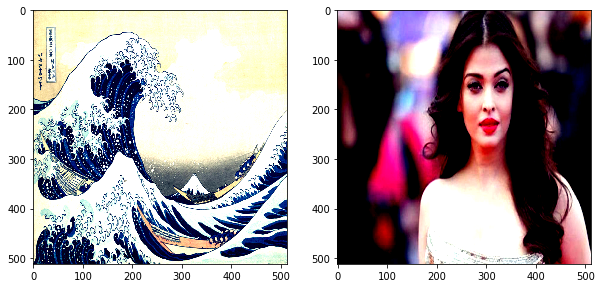

In [8]:
fig=plt.figure(figsize=(10,10))
def show(tensor,i):
    ax=fig.add_subplot(1,2,i)
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array([0.485, 0.456, 0.406])+np.array([0.229, 0.224, 0.225])   #bring back to 
    image = image.clip(0, 1)
    plt.imshow(image)
show(style_img,1)
show(content_img,2)

In [9]:
#weights remain same so get activation maps for content and style image in each layer for given image
def get_features(image,vgg19,layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '23': 'conv4_3',  ## content representation
                  '28': 'conv5_1'}
    x=image
    features={}
    for name,layer in vgg19._modules.items():
        x=layer(x)#get activation map for each conv layer
        if name in layers:
            features[layers[name]]=x
    return features

In [11]:
def gram_matrix(tensor):
    _,d,h,w=tensor.shape
    tensor=tensor.view(d,h*w)
    gram=torch.mm(tensor,tensor.t())
    return gram 

In [12]:
style_features=get_features(style_img,model) #a dict key-layername:value-actiavtion map with depth 
content_features=get_features(content_img,model)

gram={layer: gram_matrix(style_features[layer]) for layer in style_features}
#create a copy of content image to target start with target and backprop to style
target=content_img.clone().requires_grad_(True).to(device)

In [19]:
gram['conv4_3'].shape

torch.Size([512, 512])

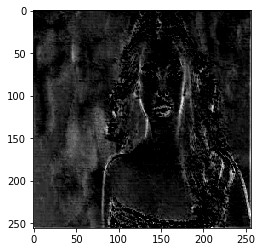

In [15]:
#visualize for different activation 
imag=content_features['conv2_1'].squeeze()[42]
plt.imshow(imag.to('cpu'),cmap='gray')

In [17]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
#becoz it represents style,textures
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e8  # beta


In [18]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image *np.array([0.485, 0.456, 0.406])+np.array([0.229, 0.224, 0.225])
    image = image.clip(0, 1)
    return image

131495116800.0


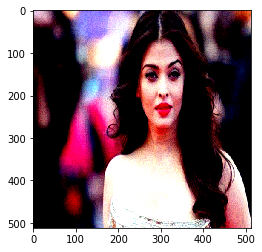

299644480.0


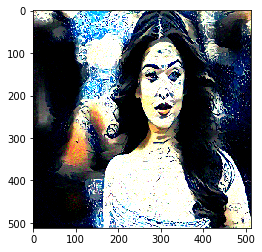

157283760.0


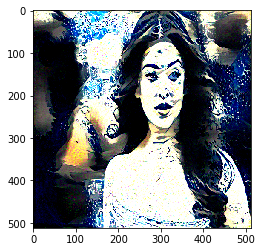

196956464.0


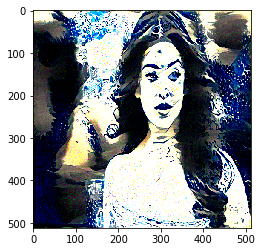

89008688.0


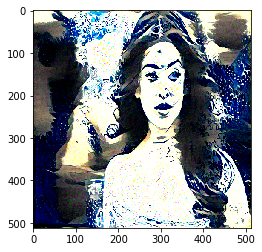

74050432.0


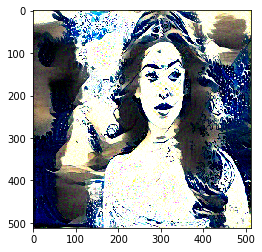

68488496.0


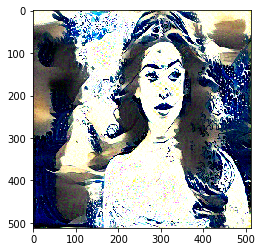

194198608.0


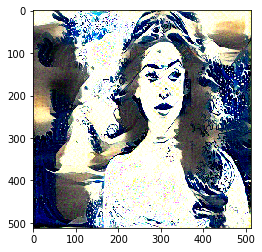

In [19]:
show_every=400
optimizer=optim.Adam([target],lr=0.1)
for i in range(3000):
    #content loss for 4th layer from paper 
    optimizer.zero_grad()
    target_features=get_features(target,model)
    content_loss=torch.mean((target_features['conv4_3']-content_features['conv4_3'])**2)
        #style loss
    style_loss=0
    for layers in style_weights:
        _,d,w,h=target_features[layers].shape #for norm style loss
        target_gram=gram_matrix(target_features[layers]) #activation map ka gram matrix
        style_gram=gram[layers]
        layer_loss=style_weights[layers]*torch.mean((style_gram-target_gram)**2)
        style_loss+=layer_loss/(d*w*h) #normalize
    target_loss=content_weight*content_loss+style_weight*style_loss
    target_loss.backward()
    optimizer.step()
    if i%show_every==0:
        print(target_loss.item())
        plt.figure()
        plt.imshow(im_convert(target))
        plt.show()

In [20]:
A=im_convert(target)
#from PIL import Image
import matplotlib

matplotlib.image.imsave('ART.jpg', A)